In [1]:
import json

# read jsonl file
path = "/mnt/ssd/Projects/lmms-eval/outputs/hrbench-qwen3vl-30ba3b-fp8/Qwen__Qwen3-VL-30B-A3B-Thinking-FP8/20251006_013637_samples_hrbench4k.jsonl"
with open(path, "r") as f:
    data = [json.loads(line) for line in f]

print(data[:5])  # print first 5 entries

[{'doc_id': 0, 'target': 'A', 'filtered_resps': ['Okay, let\'s see. The user is asking about the number displayed above the entrance where the woman is standing. The options are A to D, with different numbers and letters.\n\nFirst, I need to look at the image. The entrance has a sign above it. Let me check the image again. The sign says "27B". So the number is 27 with a B. The options include A as 27B, which matches. The other options have different numbers or letters. B is 37B, which is different. C is 27D, D is 27E. So the correct answer should be A.\n\nWait, let me make sure. The image shows the number "27B" clearly above the doorway. The woman is standing in front of that entrance. So yes, the answer is A.\n</think>\n\nA'], 'doc_hash': '74234e98afe7498fb5daf1f36ac2d78acc339464f950703b8c019892f982b90b', 'single': {'index': 0, 'cycle_category': '0', 'gpt_score': 1}, 'average': {'index': 0, 'cycle_category': '0', 'gpt_score': 1}, 'input': 'What is the number displayed above the entran

In [2]:
# Reorganize the data entries
reorganized_data = {0: [], 1: []}
for e in data:
    score = e["average"]["gpt_score"]
    reorganized_data[score].append(
        {
            "question": e["input"],
            "target": e["target"],
            "response": e["filtered_resps"][0],
        }
    )

print(reorganized_data[0][0])  # print first entry of score 0

{'question': 'Is the mailbox on the left or right side of the woman?\nA. Right\nB. Directly above\nC. In front\nD. Left\n', 'target': 'A', 'response': "Okay, let's see. The question is asking whether the mailbox is on the left or right side of the woman. The options are A. Right, B. Directly above, C. In front, D. Left.\n\nFirst, I need to look at the image. The woman is standing near a building. She's holding a phone in her right hand and has a bag over her shoulder. Her left hand is touching a column. Now, where is the mailbox?\n\nLooking at the background, there's a blue mailbox on the wall behind her. Let me check the position. The woman is facing to the left side of the image. The mailbox is on the wall to her right side. Wait, if she's standing there, her right side would be towards the right of the image. Wait, no. Wait, the woman is facing left, so her left side is towards the left of the image. Wait, no. Wait, when you look at the image, the woman is facing to the left. So her

In [3]:
print(len(reorganized_data[0]), len(reorganized_data[1]))  # print lengths of both lists

220 580


/mnt/ssd/Projects/lmms-eval/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


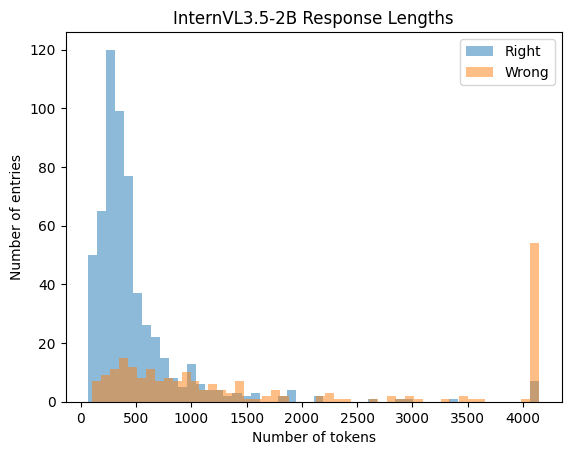

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-VL-30B-A3B-Thinking-FP8")
# draw histogram of lengths
import matplotlib.pyplot as plt

lengths_0 = []
lengths_1 = []
for score in [0, 1]:
    for entry in reorganized_data[score]:
        input_text = entry["question"] + " " + entry["response"]
        tokens = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=8192)
        if score == 0:
            lengths_0.append(tokens.input_ids.shape[1])
        else:
            lengths_1.append(tokens.input_ids.shape[1])

plt.hist(lengths_1, bins=50, alpha=0.5, label="Right")
plt.hist(lengths_0, bins=50, alpha=0.5, label="Wrong")
# Make y-axis break
plt.xlabel("Number of tokens")
plt.ylabel("Number of entries")
plt.legend()
plt.title("InternVL3.5-2B Response Lengths")
plt.show()

In [6]:
# find the most used tokens in each score group
from collections import Counter

counter_0 = Counter()
counter_1 = Counter()
for score in [0, 1]:
    for entry in reorganized_data[score]:
        input_text = entry["question"] + " " + entry["response"]
        tokens = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=8192)
        if score == 0:
            counter_0.update(tokens.input_ids[0].tolist())
        else:
            counter_1.update(tokens.input_ids[0].tolist())

for token_id, count in counter_0.most_common(10):
    print(f"Token ID: {token_id}, Count in score 0: {count}, Token: {tokenizer.decode([token_id])}")
for token_id, count in counter_1.most_common(10):
    print(f"Token ID: {token_id}, Count in score 1: {count}, Token: {tokenizer.decode([token_id])}")

Token ID: 279, Count in score 0: 478688, Token:  the
Token ID: 13, Count in score 0: 354705, Token: .
Token ID: 11, Count in score 0: 315443, Token: ,
Token ID: 374, Count in score 0: 227156, Token:  is
Token ID: 13824, Count in score 0: 78999, Token:  Wait
Token ID: 220, Count in score 0: 75915, Token:  
Token ID: 1988, Count in score 0: 73631, Token:  But
Token ID: 4226, Count in score 0: 66611, Token:  answer
Token ID: 525, Count in score 0: 60446, Token:  are
Token ID: 323, Count in score 0: 56925, Token:  and
Token ID: 279, Count in score 1: 10384, Token:  the
Token ID: 13, Count in score 1: 8668, Token: .
Token ID: 11, Count in score 1: 5451, Token: ,
Token ID: 374, Count in score 1: 4653, Token:  is
Token ID: 576, Count in score 1: 3348, Token:  The
Token ID: 389, Count in score 1: 2059, Token:  on
Token ID: 264, Count in score 1: 2021, Token:  a
Token ID: 315, Count in score 1: 1832, Token:  of
Token ID: 304, Count in score 1: 1609, Token:  in
Token ID: 220, Count in score 1: 1